# 生成双摆哈密顿量数据

Starting simulation...
Simulation finished.
Initial Energy: -0.000000
Max relative energy variation: 1.50e+09


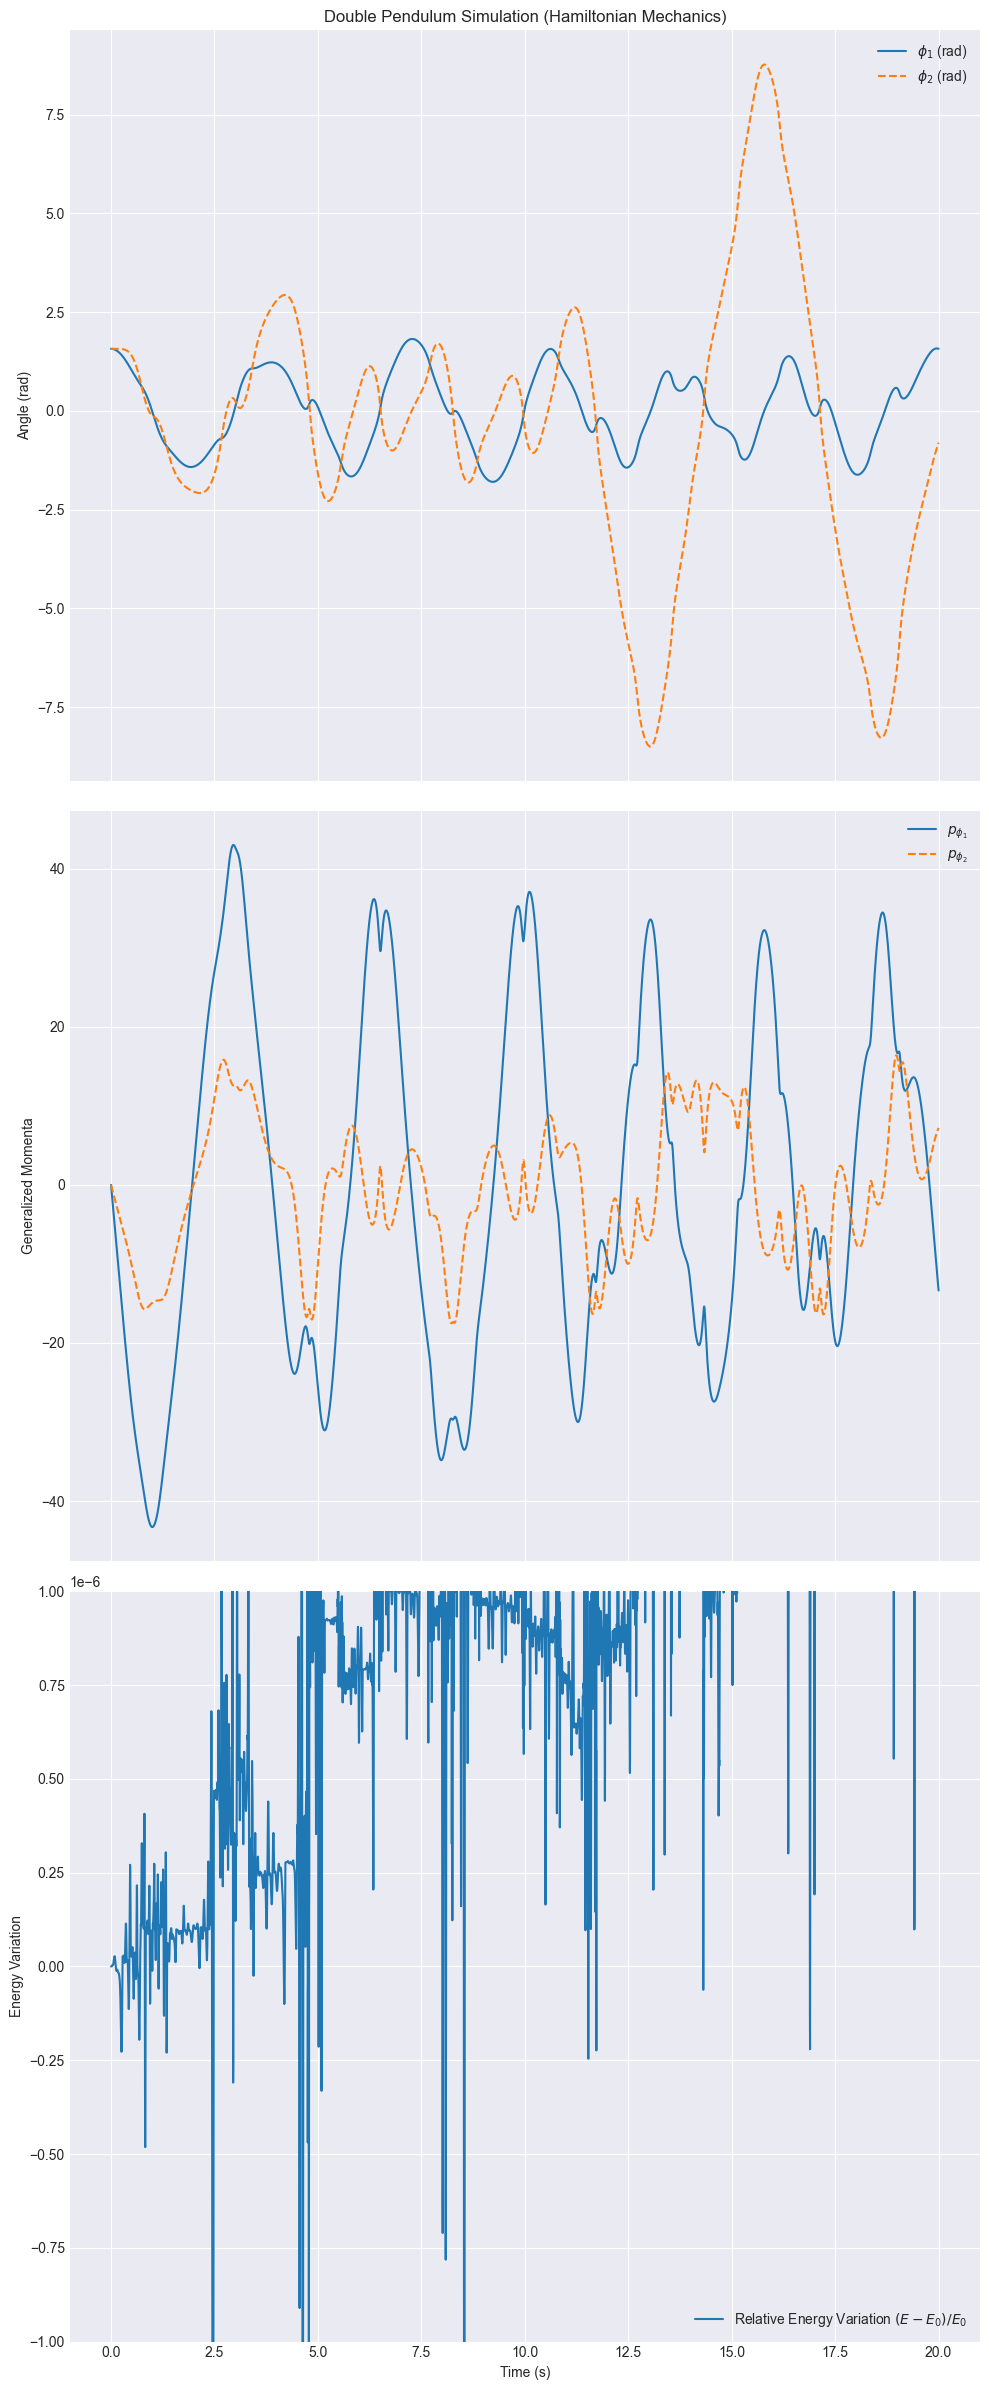

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. Define System Parameters
# ===========================
# Masses (kg)
m1 = 1.0
m2 = 2.0
# Lengths (m)
l1 = 2.0
l2 = 1.0
# Gravity (m/s^2)
g = 9.81

params = {
    'm1': m1,
    'm2': m2,
    'l1': l1,
    'l2': l2,
    'g': g
}

# 2. Define the Hamiltonian Function
# ==================================
def hamiltonian(state, params):
    """Calculates the Hamiltonian (total energy) of the double pendulum.

    Args:
        state (array-like): Current state [phi1, phi2, p_phi1, p_phi2].
        params (dict): Dictionary of system parameters (m1, m2, l1, l2, g).

    Returns:
        float: The value of the Hamiltonian.
    """
    phi1, phi2, p_phi1, p_phi2 = state
    m1, m2, l1, l2, g = params['m1'], params['m2'], params['l1'], params['l2'], params['g']

    c = np.cos(phi1 - phi2) # cos(phi1 - phi2)
    s = np.sin(phi1 - phi2) # sin(phi1 - phi2)

    # Denominator term appearing in kinetic energy (T)
    # Factor of 2 is included here for convenience
    den = 2 * m2 * l1**2 * l2**2 * (m1 + m2 * s**2)

    # If denominator is zero (e.g., aligned pendulum, potential numerical issue),
    # return infinity or handle appropriately. Here we add a small epsilon.
    epsilon = 1e-12
    if abs(den) < epsilon:
       # Handle singularity - perhaps return large value or NaN
       # For simplicity, we'll use a large value, but this case needs careful thought
       # depending on the application. It typically occurs when phi1=phi2 and m1=0.
       print("Warning: Near singular configuration detected.")
       return np.inf


    # Kinetic Energy (T)
    T_num = (m2 * l2**2 * p_phi1**2 +
             (m1 + m2) * l1**2 * p_phi2**2 -
             2 * m2 * l1 * l2 * c * p_phi1 * p_phi2)
    T = T_num / den

    # Potential Energy (V)
    V = -(m1 + m2) * g * l1 * np.cos(phi1) - m2 * g * l2 * np.cos(phi2)

    return T + V

# 3. Define Hamilton's Equations (Derivatives)
# ============================================
def hamiltonian_derivatives(t, state, params):
    """Calculates the time derivatives of the state variables (Hamilton's equations).

    Args:
        t (float): Current time (required by solve_ivp, but not used here as H is time-independent).
        state (array-like): Current state [phi1, phi2, p_phi1, p_phi2].
        params (dict): Dictionary of system parameters (m1, m2, l1, l2, g).

    Returns:
        list: The time derivatives [dphi1/dt, dphi2/dt, dp_phi1/dt, dp_phi2/dt].
    """
    phi1, phi2, p_phi1, p_phi2 = state
    m1, m2, l1, l2, g = params['m1'], params['m2'], params['l1'], params['l2'], params['g']

    c = np.cos(phi1 - phi2)
    s = np.sin(phi1 - phi2)
    s_sq = s**2

    # Common denominator part (without the factor of 2 from H definition)
    # We use the expression derived before H, i.e., det(A) / (m2 * l1 * l2)
    den_common = l1 * l2 * (m1 + m2 * s_sq)

    # Avoid division by zero if denominator is close to zero
    epsilon = 1e-12
    if abs(den_common) < epsilon:
        print("Warning: Near singular configuration for derivatives.")
        # Return zero derivatives or handle as appropriate
        return [0, 0, 0, 0]


    # Calculate d(phi1)/dt = dH/d(p_phi1)
    dphi1_dt_num = l2 * p_phi1 - l1 * p_phi2 * c
    dphi1_dt = dphi1_dt_num / (l1 * den_common)

    # Calculate d(phi2)/dt = dH/d(p_phi2)
    dphi2_dt_num = l1 * (m1 + m2) * p_phi2 - l2 * m2 * p_phi1 * c
    dphi2_dt = dphi2_dt_num / (m2 * l2 * den_common)

    # Calculate d(p_phi1)/dt = -dH/d(phi1)
    # This is derived from -(dT/dphi1 + dV/dphi1) = dL/dphi1
    # Term from dT/dphi1 (and dL/dphi1): -m2*l1*l2*dphi1_dt*dphi2_dt*sin(phi1-phi2)
    # Term from dV/dphi1 (and -dL/dphi1): -(m1+m2)*g*l1*sin(phi1)
    term_for_dp = m2 * l1 * l2 * dphi1_dt * dphi2_dt * s
    dp_phi1_dt = -(m1 + m2) * g * l1 * np.sin(phi1) - term_for_dp

    # Calculate d(p_phi2)/dt = -dH/d(phi2)
    # This is derived from -(dT/dphi2 + dV/dphi2) = dL/dphi2
    # Term from dT/dphi2 (and dL/dphi2): +m2*l1*l2*dphi1_dt*dphi2_dt*sin(phi1-phi2)
    # Term from dV/dphi2 (and -dL/dphi2): -m2*g*l2*sin(phi2)
    dp_phi2_dt = -m2 * g * l2 * np.sin(phi2) + term_for_dp

    return [dphi1_dt, dphi2_dt, dp_phi1_dt, dp_phi2_dt]


# 4. Simulation Setup
# =====================
# Initial conditions: [phi1_0, phi2_0, p_phi1_0, p_phi2_0]
# Start with both bobs hanging vertically down but slightly perturbed, at rest.
# phi1 = pi, phi2 = pi (downward), p_phi1 = 0, p_phi2 = 0
# Let's start near the top: phi1=pi/2, phi2=pi/2, zero initial momenta
initial_state = [np.pi / 2 , np.pi / 2, 0.0, 0.0]
# Or a common chaotic initial condition:
# initial_state = [np.pi/2, np.pi/2, 0.0, 0.0]
# initial_state = [3*np.pi/4, np.pi/2, 0.0, 0.0]

# Time span for the simulation (seconds)
t_start = 0.0
t_end = 20.0
t_span = (t_start, t_end)

# Time points where the solution is computed
n_points = 6000
t_eval = np.linspace(t_start, t_end, n_points)

# 5. Run the Simulation
# =====================
print("Starting simulation...")
sol = solve_ivp(
    hamiltonian_derivatives,
    t_span,
    initial_state,
    args=(params,),
    method='DOP853', #'DOP853' can be more accurate but slower
    t_eval=t_eval,
    rtol=1e-8, # Relative tolerance
    atol=1e-8  # Absolute tolerance
)
print("Simulation finished.")

# Check if simulation was successful
if not sol.success:
    print(f"Solver failed: {sol.message}")
else:
    # 6. Process and Visualize Results
    # ================================
    # Extract results
    phi1_sol = sol.y[0]
    phi2_sol = sol.y[1]
    p_phi1_sol = sol.y[2]
    p_phi2_sol = sol.y[3]
    times = sol.t

    # Calculate Hamiltonian (energy) over time to check conservation
    energy = np.array([hamiltonian(state, params) for state in sol.y.T])
    initial_energy = energy[0]
    energy_variation = (energy - initial_energy) / initial_energy

    print(f"Initial Energy: {initial_energy:.6f}")
    print(f"Max relative energy variation: {np.max(np.abs(energy_variation)):.2e}")

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-darkgrid') # Nicer plot style
    fig, axs = plt.subplots(3, 1, figsize=(10, 24), sharex=True)

    # Plot Angles
    axs[0].plot(times, phi1_sol, label=r'$\phi_1$ (rad)')
    axs[0].plot(times, phi2_sol, label=r'$\phi_2$ (rad)', linestyle='--')
    axs[0].set_ylabel('Angle (rad)')
    axs[0].legend()
    axs[0].set_title('Double Pendulum Simulation (Hamiltonian Mechanics)')

    # Plot Momenta
    axs[1].plot(times, p_phi1_sol, label=r'$p_{\phi_1}$')
    axs[1].plot(times, p_phi2_sol, label=r'$p_{\phi_2}$', linestyle='--')
    axs[1].set_ylabel('Generalized Momenta')
    axs[1].legend()

    # Plot Energy Conservation
    axs[2].plot(times, energy, label='Relative Energy Variation $(E-E_0)/E_0$')
    axs[2].set_ylabel('Energy Variation')
    axs[2].set_xlabel('Time (s)')
    axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Scientific notation for y-axis
    axs[2].legend()
    axs[2].set_ylim(bottom=-1e-6, top=1e-6) # Zoom if variation is small


    plt.tight_layout()
    plt.show()

    # Optional: Convert to Cartesian coordinates for animation later
    # x1 = l1 * np.sin(phi1_sol)
    # y1 = -l1 * np.cos(phi1_sol) # Negative because y often points up in plots
    # x2 = x1 + l2 * np.sin(phi2_sol)
    # y2 = y1 - l2 * np.cos(phi2_sol)


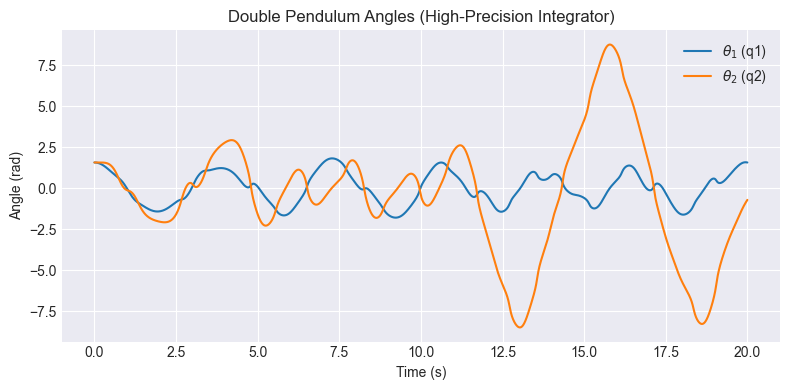

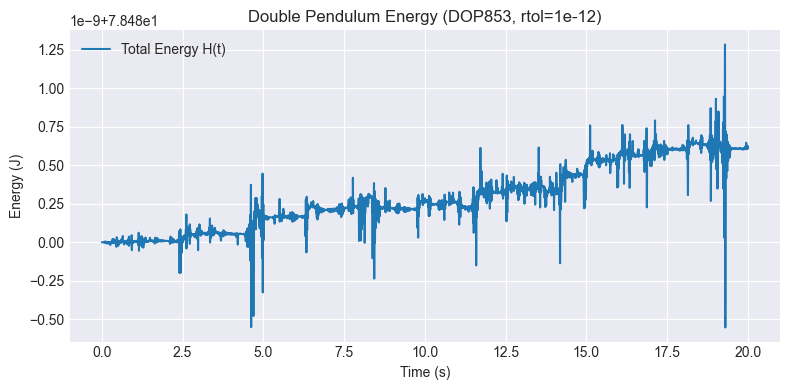

In [10]:
#!/usr/bin/env python3
# double_pendulum_high_precision.py

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 系统参数
m1, m2 = 1.0, 2.0     # 质量
l1, l2 = 2.0, 1.0     # 摆长
g = 9.81              # 重力加速度

def hamiltonian_derivs(t, y):
    """
    Hamilton 方程的右端函数：
    y = [q1, q2, p1, p2]
    返回 [dq1, dq2, dp1, dp2]
    """
    q1, q2, p1, p2 = y
    # 质量矩阵元素
    a = (m1 + m2) * l1**2
    b = m2 * l1 * l2 * np.cos(q1 - q2)
    c = m2 * l2**2
    Delta = a * c - b**2

    # 广义速度 dq_i = ∂H/∂p_i
    dq1 = (c * p1 - b * p2) / Delta
    dq2 = (a * p2 - b * p1) / Delta

    # 势能对广义坐标的偏导 ∂V/∂q_i
    dV_dq1 = (m1 + m2) * g * l1 * np.sin(q1)
    dV_dq2 = m2 * g * l2 * np.sin(q2)

    # 广义动量的演化 dp_i = -∂H/∂q_i
    dp1 = -dV_dq1 - m2 * l1 * l2 * np.sin(q1 - q2) * dq1 * dq2
    dp2 = -dV_dq2 + m2 * l1 * l2 * np.sin(q1 - q2) * dq1 * dq2

    return [dq1, dq2, dp1, dp2]

def compute_energy(q1, q2, p1, p2):
    """计算哈密顿量 H = T + V"""
    a = (m1 + m2) * l1**2
    b = m2 * l1 * l2 * np.cos(q1 - q2)
    c = m2 * l2**2
    Delta = a * c - b**2
    T = (c * p1**2 + a * p2**2 - 2*b*p1*p2) / (2*Delta)
    V = (m1 + m2)*g*l1*(1 - np.cos(q1)) + m2*g*l2*(1 - np.cos(q2))
    return T + V

def main():
    # 初始条件 [q1(rad), q2(rad), p1, p2]
    y0 = [np.pi/2, np.pi/2, 0.0, 0.0]
    t0, tf = 0.0, 20.0
    t_eval = np.linspace(t0, tf, 6000)

    # 用高阶 DOP853 方法，高精度积分
    sol = solve_ivp(
        fun=hamiltonian_derivs,
        t_span=(t0, tf),
        y0=y0,
        method='DOP853',
        t_eval=t_eval,
        rtol=1e-12,
        atol=1e-15
    )

    # 提取解
    q1, q2, p1, p2 = sol.y

    # 计算能量
    H = np.array([compute_energy(q1[i], q2[i], p1[i], p2[i]) 
                  for i in range(len(sol.t))])

    # 保存数据
    data = np.vstack((sol.t, q1, q2, p1, p2, H)).T
    np.savetxt("double_pendulum_high_precision.csv", data,
               header="t,q1,q2,p1,p2,H", delimiter=",")

    # 绘图：广义坐标
    plt.figure(figsize=(8, 4))
    plt.plot(sol.t, q1, label=r'$\theta_1$ (q1)')
    plt.plot(sol.t, q2, label=r'$\theta_2$ (q2)')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.legend()
    plt.title('Double Pendulum Angles (High-Precision Integrator)')
    plt.tight_layout()
    plt.show()

    # 绘图：能量守恒
    plt.figure(figsize=(8, 4))
    plt.plot(sol.t, H, label='Total Energy H(t)')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')
    plt.legend()
    plt.title('Double Pendulum Energy (DOP853, rtol=1e-12)')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
